# Setup and Initialization

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [6]:
# Load the dataset
df = pd.read_csv('./data/e-commerce-data.csv', encoding='ISO-8859-1')

df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


# Initial Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<b>Quantity</b>
The average of quantity is 9.55. It has wide range, with a min number -80,995 and a maximum number of 80,995. Negative quantity indicates returned of cancelled order.

<b>Unit Price</b>
The average of unit price is 4.61. It also have a wide range, with a min number -11,062.06 and a maximum number of 38,970. 

<b>Customer ID</b>
There are 406,829 non-null entries, indicates missing values in the dataset, which need to be handled. 

In [9]:
# Check negative quantity
# df[df["Quantity"] < 0].head(10)

In [10]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


<b>Invoice No</b>
There are 25,900 unique invoice numbers, indicating 25,900 separate transactions.

<b>StockCode</b>
There are 4,070 unique stock code to represent different products. The most frequent stock is 85123A, it appears 2,313 times in the dataset.

<b>Description</b>
There are 4,223 unique product descriptions.The most frequent description is "WHITE HANGING HEART T-LIGHT HOLDER", it appears 2,369 times in the dataset. There are total of 541,909 products, but in description it only contain 540,455 in total, there is some missing value. 

<b>Country</b>
The dataset transactions are come from 38 different countries, with 49,5478 from United Kingdom, it accounts for approximately 91.43%.

# Data Cleaning and Transformation

## Missing values

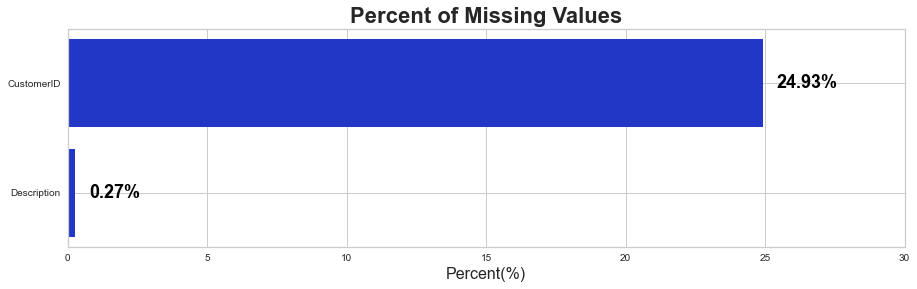

In [11]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percent = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percent.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15,4))
ax.barh(missing_percent.index, missing_percent, color='#2337C6')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percent, missing_percent.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontsize=18, fontweight='bold', color='black')

ax.set_xlim([0,30])
plt.title("Percent of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percent(%)', fontsize=16)
plt.show()

`CustomerID` (24.93%) missing nearly a quarter of data. This column is important for clustering customers. For K Means algorithm is sensitive to noise there missing such a large percent of missing values would introduce significant bias into the analysis. To handle this case, it would be better to removing the rows with missing `CustomerID` to maintain the integrity to the clusters.

`Description` (0.27%) has a minor percentage of missing values. It has been noticed that there are incosistencies in the data where the same `StockCode` does not always have the same `Description`. This indicates data quality issues and potential errors in the product description.
Moreover, fill in those descriptions based on `StockCode` might not be reliable. Therefore, it would reasonable to remove the rows with missing `Description`s to increase the realibility of the analysis.

In [12]:
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [13]:
df = df.dropna(subset={'CustomerID', 'Description'})

In [14]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Handling Duplicates

In [15]:
dup_rows = df[df.duplicated(keep=False)]
dup_rows_sorted = dup_rows.sort_values(by=['InvoiceNo', 'StockCode','Description', 'CustomerID', 'Quantity'])
dup_rows_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


In [17]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")
df.drop_duplicates(inplace=True)

The dataset contains 0 duplicate rows that need to be removed.


In [18]:
df.shape[0]

401604

## Correcting StockCode Anomalies

The number of unique stock codes in the dataset is: 3684


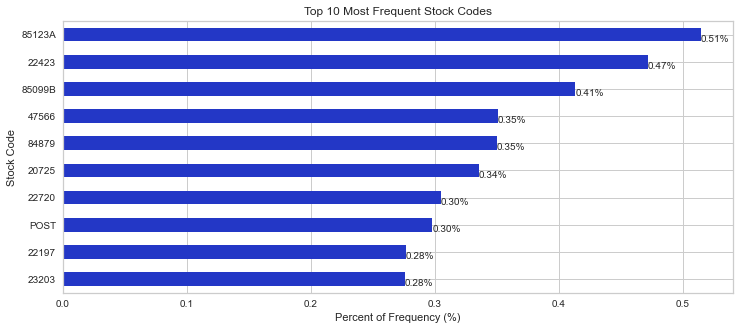

In [19]:
# Finding the number of unique stock codes
uniq_stock_code = df['StockCode'].nunique()
print(f"The number of unique stock codes in the dataset is: {uniq_stock_code}")
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the graph
plt.figure(figsize=(12,5))
top_10_stock_codes.plot(kind='barh', color='#2337C6')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%',fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percent of Frequency (%)')
plt.ylabel('Stock Code')
plt.gca().invert_yaxis()
plt.show()

**Stock Code Anomalies**: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent non-product transactions rather than actual products. To maintain the focus of the project, which is clustering based on product purchases, these anomalies should be further investigated and possibly treated appropriately to ensure data integrity.

In [20]:
uniq_stock_codes = df['StockCode'].unique()
numchar_counts_in_uniq_codes = pd.Series(uniq_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Counts of numeric character frequencies in unique stock codes: ")
print("-"*70)
print(numchar_counts_in_uniq_codes)

Counts of numeric character frequencies in unique stock codes: 
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


- A majority of the unique stock codes (3,676 out of 3,684) contain exactly 5 numeric characters, which seems to be the standard format in this dataset. 
- There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. 

In [21]:
anomalous_stock_codes = [code for code in uniq_stock_codes if sum(c.isdigit() for c in str(code)) in (0,1)]

print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [22]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous: .2f}%")

The percentage of records with anomalous stock codes in the dataset is:  0.48%


Based on the analysis, only a small proportion of the records, 0.48%, have anomalous stock codes, which deviate from the typical format. Also, these anomalous codes are just a fraction among all unique stock codes (only 8 out of 3684). To cater this, we will filter out and remove these anomalous stock codes, to provide a more accurate and meaningful analysis.

In [23]:
df=df[~df['StockCode'].isin(anomalous_stock_codes)]

In [24]:
df.shape[0]

399689

## Treating Cancelled Transactions

In [38]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice,Total_Spend,Day_Of_Week,Hour
count,8506.000000,8506.000000,8506.000000,8506.000000,8506.000000
mean,-31.473195,4.440148,-55.460935,2.246767,13.164707
std,1197.051599,9.199140,2014.136001,1.567941,2.725848
min,-80995.000000,0.030000,-168469.600000,0.000000,6.000000
25%,-6.000000,1.450000,-16.597500,1.000000,11.000000
50%,-2.000000,2.550000,-8.300000,2.000000,13.000000
75%,-1.000000,4.950000,-3.300000,3.000000,15.000000
max,-1.000000,295.000000,-0.120000,6.000000,20.000000


- All quantities in the cancelled transactions are negative, indicating that these are indeed orders that were cancelled.

In [25]:
df.reset_index(drop=True, inplace=True)

In [26]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Analytics

## RFM Features

In [27]:
# Recency: calculate most recent purchase date with the latest purchase date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDay"] = df["InvoiceDate"].dt.date
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

most_recent_date = df['InvoiceDay'].max()
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

customer_data['Day_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [28]:
customer_data.head()

,CustomerID,Day_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [29]:
# Frequency: will calculate the total transactions per customer, and total number of products purchased
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

total_num_products_purchased = df.groupby('CustomerID')['Quantity'].nunique().reset_index()
total_num_products_purchased.rename(columns={'Quantity': 'Total_Number_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_num_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Number_Products_Purchased
0,12346.0,325,2,2
1,12347.0,2,7,15
2,12348.0,75,4,8
3,12349.0,18,1,12
4,12350.0,310,1,4


In [30]:
# Monetary: will calculate the total spending of each customer and average transaction value.
df['Total_Spend'] = df['Quantity'] * df['UnitPrice']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend']/average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Number_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,2,0.00,0.000000
1,12347.0,2,7,15,4310.00,615.714286
2,12348.0,75,4,8,1437.24,359.310000
3,12349.0,18,1,12,1457.55,1457.550000
4,12350.0,310,1,4,294.40,294.400000


## Behavioral Features

Favorite Shopping Day, Favorite Shopping Hour

In [31]:
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Number_Products_Purchased,Total_Spend,Average_Transaction_Value,Day_Of_Week,Hour
0,12346.0,325,2,2,0.00,0.000000,1,10
1,12347.0,2,7,15,4310.00,615.714286,1,14
2,12348.0,75,4,8,1437.24,359.310000,3,19
3,12349.0,18,1,12,1457.55,1457.550000,0,9
4,12350.0,310,1,4,294.40,294.400000,2,16


## Product Diversity

In [32]:
uniq_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
uniq_products_purchased.rename(columns={'StockCode': 'Unique_Product_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, uniq_products_purchased, on='CustomerID')
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Number_Products_Purchased,Total_Spend,Average_Transaction_Value,Day_Of_Week,Hour,Unique_Product_Purchased
0,12346.0,325,2,2,0.00,0.000000,1,10,1
1,12347.0,2,7,15,4310.00,615.714286,1,14,103
2,12348.0,75,4,8,1437.24,359.310000,3,19,21
3,12349.0,18,1,12,1457.55,1457.550000,0,9,72
4,12350.0,310,1,4,294.40,294.400000,2,16,16


## Geographical

In [33]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.890968
Germany           0.022720
France            0.020396
EIRE              0.018439
Spain             0.006162
Name: Country, dtype: float64

In [34]:
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Number_Products_Purchased,Total_Spend,Average_Transaction_Value,Day_Of_Week,Hour,Unique_Product_Purchased,Is_UK
0,12346.0,325,2,2,0.00,0.000000,1,10,1,1
1,12347.0,2,7,15,4310.00,615.714286,1,14,103,0
2,12348.0,75,4,8,1437.24,359.310000,3,19,21,0
3,12349.0,18,1,12,1457.55,1457.550000,0,9,72,0
4,12350.0,310,1,4,294.40,294.400000,2,16,16,0


In [35]:
customer_data['Is_UK'].value_counts()

1    3943
0     420
Name: Is_UK, dtype: int64

## Cancellation of orders

Cancellation Frequency for total number of transactions a customer has canceled, Cancellation Rate the proportion of transactions that a customer has canceled out of all their transactions

In [39]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Number_Products_Purchased,Total_Spend,Average_Transaction_Value,Day_Of_Week,Hour,Unique_Product_Purchased,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,2,0.00,0.000000,1,10,1,1,1.0,0.5
1,12347.0,2,7,15,4310.00,615.714286,1,14,103,0,0.0,0.0
2,12348.0,75,4,8,1437.24,359.310000,3,19,21,0,0.0,0.0
3,12349.0,18,1,12,1457.55,1457.550000,0,9,72,0,0.0,0.0
4,12350.0,310,1,4,294.40,294.400000,2,16,16,0,0.0,0.0


## Seasonality & Trends

Monthly_Spending_Mean, Monthly_Spending_Std, Spending_Trend

In [42]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Day_Since_Last_Purchase,Total_Transactions,Total_Number_Products_Purchased,Total_Spend,Average_Transaction_Value,Day_Of_Week,Hour,Unique_Product_Purchased,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,2,0.00,0.000000,1,10,1,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,15,4310.00,615.714286,1,14,103,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,8,1437.24,359.310000,3,19,21,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,12,1457.55,1457.550000,0,9,72,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,4,294.40,294.400000,2,16,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [43]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [44]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 0 to 4362
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CustomerID                       4363 non-null   string 
 1   Day_Since_Last_Purchase          4363 non-null   Int64  
 2   Total_Transactions               4363 non-null   Int64  
 3   Total_Number_Products_Purchased  4363 non-null   Int64  
 4   Total_Spend                      4363 non-null   Float64
 5   Average_Transaction_Value        4363 non-null   Float64
 6   Day_Of_Week                      4363 non-null   Int64  
 7   Hour                             4363 non-null   Int64  
 8   Unique_Product_Purchased         4363 non-null   Int64  
 9   Is_UK                            4363 non-null   Int64  
 10  Cancellation_Frequency           4363 non-null   Int64  
 11  Cancellation_Rate                4363 non-null   Float64
 12  Monthly_Spending_Mea